# Proyecto 4
## Informe Final Carrera
### Fernando Dolci

En este proyecto continuare con lo desarrollado en el proyecto 3 (Series de Tiempo), incorporando nuevos modelos con la intención de mejorar lo entregado en el proyecto anterior

In [82]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from datetime import datetime, timedelta
import datetime as dt

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')


from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline


matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

Cargamos el dataset del 2020 y lo trabajamos para que quede coincidente con los otros (2019/2018/2017) ya que como vimos en el proyecto anterior, tiene diferente estructura

In [83]:
# Importamos el csv del 2020
data_2020 = pd.read_csv('../DatasetsProyectos/flujo-vehicular-2020.csv', sep =',')

#Quitamos las columnas que no vamos a utilizar
data_2020.drop(columns = ['mes','dia_fecha','observacion'], inplace = True)

#Corregimos diferencias en este nuevo set
data_2020['estacion'].replace('ILLIA', 'Illia',  inplace=True)

# Corregimos la etiqueta forma_pago para el 2020
data_2020['forma_pago'].replace('Efectivo', 'EFECTIVO',  inplace=True)

# Realizamos una correccion del tipo_vehiculo para el 2020
data_2020['tipo_vehiculo'].replace('Pesado 2 Ejes', 'Pesado',  inplace=True)
data_2020['tipo_vehiculo'].replace('Pesados 2 Ejes', 'Pesado',  inplace=True)
data_2020['tipo_vehiculo'].replace('Pesados 3 Ejes', 'Pesado',  inplace=True)
data_2020['tipo_vehiculo'].replace('Pesados 4 Ejes', 'Pesado',  inplace=True)
data_2020['tipo_vehiculo'].replace('Pesados 5 Ejes', 'Pesado',  inplace=True)
data_2020['tipo_vehiculo'].replace('Pesados 6 Ejes', 'Pesado',  inplace=True)
data_2020['tipo_vehiculo'].replace('Pago Doble Auto con trailer / Pesado 2 Ejes', 'Pesado',  inplace=True)
data_2020['tipo_vehiculo'].replace('Pago Doble Auto', 'Pesado',  inplace=True)
data_2020['tipo_vehiculo'].replace('Auto', 'Liviano',  inplace=True)
data_2020['tipo_vehiculo'].replace('Auto con trailer', 'Liviano',  inplace=True)
data_2020['tipo_vehiculo'].replace('Moto', 'Liviano',  inplace=True)
data_2020['tipo_vehiculo'].replace('Pago doble Moto', 'Liviano',  inplace=True)


In [84]:
# Importamos el csv del 2017
data_2017 = pd.read_csv('../DatasetsProyectos/flujo-vehicular-2017.csv', sep =',')

# Importamos el csv del 2018
data_2018 = pd.read_csv('../DatasetsProyectos/flujo-vehicular-2018.csv', sep =',')

# Importamos el csv del 2019
data_2019 = pd.read_csv('../DatasetsProyectos/flujo-vehicular-2019.csv', sep =',')


In [85]:
# Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

In [86]:
# Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]
dataset.drop(columns=['estacion', 'forma_pago'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

# Renombramos la fecha a fecha_original para no perderla
dataset.rename(columns = {'fecha':'fecha_original'}, inplace = True) 

# dataset.drop(columns=['hora_fin'], inplace = True)

dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['hora_inicio', 'periodo', 'hora_fin' ], inplace = True)


#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)


In [87]:
dataset

fecha_original      dia    sentido tipo_vehiculo  cantidad_pasos  \
0          2017-01-01  Domingo  Provincia        Pesado               1   
1          2017-01-01  Domingo  Provincia       Liviano               9   
2          2017-01-01  Domingo  Provincia       Liviano             644   
3          2017-01-01  Domingo  Provincia        Pesado               6   
4          2017-01-01  Domingo  Provincia        Pesado               1   
...               ...      ...        ...           ...             ...   
238864     2019-12-31   Martes  Provincia       Liviano             556   
238865     2019-12-31   Martes  Provincia        Pesado               1   
238866     2019-12-31   Martes     Centro       Liviano             580   
238867     2019-12-31   Martes     Centro       Liviano             214   
238868     2019-12-31   Martes  Provincia       Liviano             190   

                     fecha  
0      2017-01-01 00:00:00  
1      2017-01-01 00:00:00  
2      2017-01-01 00:00:00  
3      2017-01-01 00:00:00  
4      2017-01-01 00:00:00  
...                    ...  
238864 2019-12-31 22:00:00  
238865 2019-12-31 22:00:00  
238866 2019-12-31 22:00:00  
238867 2019-12-31 23:00:00  
238868 2019-12-31 23:00:00  

[238869 rows x 6 columns]

In [88]:
# Completamos los dias faltantes con el promedio del dia_anterior y dia_siguiente
arrDayOfWeek={0:'Domingo', 1:'Lunes', 2:'Martes', 3:'Miercoles', 4:'Jueves', 5:'Viernes', 6:'Sabado'}
def datetime_range(start=None, end=None):
    while start < end:
        ## existe ese dia?
        temp = dataset[(dataset.fecha == start)]
        if temp.empty:
            # No existe este dia, lo agregamos en null
            dds = int(start.strftime("%w"))
            dia_de_la_semana = arrDayOfWeek[dds]
            
            dia_anterior = start - timedelta(days=1)
            s_dia_anterior = dia_anterior.strftime("%Y-%m-%d")
            cantidad_anterior = dataset.cantidad_pasos[(dataset.fecha_original == s_dia_anterior)].sum()
            
            dia_siguiente  = start + timedelta(days=1)
            s_dia_siguiente = dia_siguiente.strftime("%Y-%m-%d")
            cantidad_siguiente = dataset.cantidad_pasos[(dataset.fecha_original == s_dia_siguiente)].sum()
            
            promedio = (cantidad_anterior + cantidad_siguiente) / 2
            fecha_original = start.strftime("%Y-%m-%d")
            
            ## Calcular directamente el promedio de los dias adyacentes
            dataset.loc[dataset.shape[0]] = [fecha_original, dia_de_la_semana, 'Provincia','Liviano', promedio, start] 
            print("Añadido el dia: ", start, promedio)
            
        start = start + timedelta(days=1)
        
datetime_range(start=datetime.strptime('2017-01-01', "%Y-%m-%d"), end=datetime.strptime('2019-12-31', "%Y-%m-%d"))

Añadido el dia:  2017-04-06 00:00:00 55537.0
Añadido el dia:  2017-11-04 00:00:00 48845.5
Añadido el dia:  2018-06-25 00:00:00 38312.5
Añadido el dia:  2018-09-25 00:00:00 41299.5
Añadido el dia:  2018-11-10 00:00:00 40806.0
Añadido el dia:  2018-11-29 00:00:00 21862.0
Añadido el dia:  2018-11-30 00:00:00 20970.0
Añadido el dia:  2019-02-11 00:00:00 39980.0
Añadido el dia:  2019-05-29 00:00:00 40353.5
Añadido el dia:  2019-12-24 00:00:00 33440.0


In [89]:
# Resampleamos nuestros datos para agrupar por semana, y asi tal vez lograr una visualización mas amigable
semanal = dataset.resample('W', on = 'fecha').sum().reset_index()

# Elimino la 1er y ultima semana, ya que estan incompletas
semanal.drop(0,axis=0, inplace=True)
semanal.drop(157,axis=0, inplace=True)
semanal.reset_index()
semanal = semanal.set_index('fecha')

# semanal['2019']

### En este punto tengo el dataset ordenado para la estacion Illia y pago en efectivo para los años 2017 - 2018 y 2019


# Primera visualización de los datos

Visualizamos el trafico vehicular de nuestra serie de tiempo

In [90]:
semanal.plot(figsize=(15, 6))
plt.show()

Tambien podemos visualizar los datos utilizando una metodo llamado "Descomposición de Series de Tiempo", 
el cual nos permite descomponer la serie en 3 componentes distintos: Tendencia, estacionalidad y ruido

In [91]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(semanal, model='additive')
fig = decomposition.plot()
plt.show()

# Entrenamiento y prediccion de un modelo ARIMA 


In [92]:
p = q = range(0, 4)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Ejemplos de combinaciones de parametros para Seasonal ARIMA:')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Ejemplos de combinaciones de parametros para Seasonal ARIMA:
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)


En este paso seleccionamos los parametros de nuestra Serie de Tiempo. 
Usare "Grid Search" para encontrar el set de parametros óptimo que logre la mejor perfomance del modelo.

Actualmente está todo el código comentado, porque demora muchísimo en encontrar los parámetros óptimos. 
Guardo esos valores en una dataset junto con su MSE. La idea es encontrar la combinación óptima con menor MSE y menor AIC
En este caso ya los encontré:

In [93]:
# Este proceso lo ejecute para encontrar el mejor modelo en base al menor MSE y el menor AIC viable
# Ahora está comentado porque insume demasiado tiempo procesarlo

# sarimax = pd.DataFrame()
# fila = 0
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         mod = sm.tsa.statespace.SARIMAX(semanal,
#                                         order=param,
#                                         seasonal_order=param_seasonal,
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False)
#         results = mod.fit()

#         pred = results.get_prediction(start=pd.to_datetime('2019-10-06'), dynamic=False) # un trimestre
        
#         y_forecasted = pred.predicted_mean.to_numpy()
#         datos = semanal['2019-10-06':]
#         y_truth = datos['cantidad_pasos'].to_numpy()
        
#         mse = ((y_forecasted - y_truth) ** 2).mean()
#         sarimax.loc[fila,'param'] = str(param)
#         sarimax.loc[fila,'param_seasonal'] = str(param_seasonal)
#         sarimax.loc[fila,'results.aic'] = results.aic
#         sarimax.loc[fila,'mse'] = str(mse)
#         fila = fila + 1

#         print('SARIMAX: {}x{}12 - AIC:{} - MSE:{}'.format(param, param_seasonal, results.aic, mse))
# print('Fin.')

In [94]:
# sarimax.sort_values('mse').head(50)
arima_rmse = np.sqrt(120758311.86712268)
print("ARIMA RMSE:",arima_rmse)

ARIMA RMSE: 10989.008684459335


El resultado obtenido sugiere que **SARIMAX: (3, 1, 1)x(3, 0, 3, 12)12** tiene bajos valores de **RMSE: 10989** y de **AIC:2628.6** , motivo por el cual lo considero como la solución óptima

In [95]:
# Ajuste del modelo ARIMA

mod = sm.tsa.statespace.SARIMAX(semanal,
                                order=(3, 1, 1),
                                seasonal_order=(3, 0, 3, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2793      0.194     -1.437      0.151      -0.660       0.102
ar.L2         -0.1848      0.102     -1.820      0.069      -0.384       0.014
ar.L3         -0.3378      0.078     -4.327      0.000      -0.491      -0.185
ma.L1         -0.2359      0.206     -1.146      0.252      -0.639       0.168
ar.S.L12      -0.2185      0.157     -1.388      0.165      -0.527       0.090
ar.S.L24       0.2377      0.159      1.490      0.136      -0.075       0.550
ar.S.L36       0.3936      0.158      2.496      0.013       0.084       0.703
ma.S.L12       0.0289      0.171      0.169      0.866      -0.307       0.365
ma.S.L24      -0.3541      0.151     -2.347      0.019      -0.650      -0.058
ma.S.L36      -0.5038      0.195     -2.589      0.010      -0.885      -0.122
sigma2      3.557e+08   3.23e-10    1.1e+18      0.0

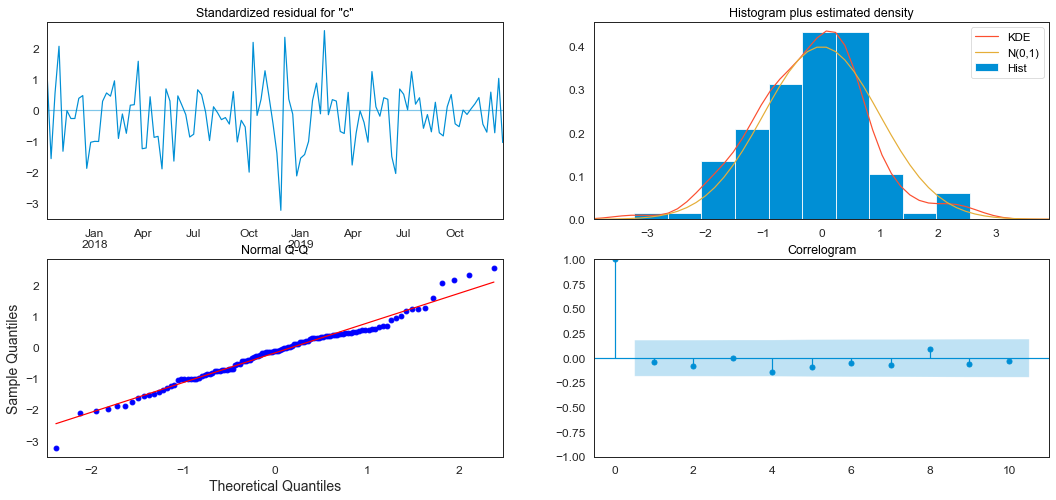

In [96]:
# Corremos los diagnosticos para investigar algun comportamiento inusual
results.plot_diagnostics(figsize=(16, 8))
plt.show()

No es perfecto, pero de todas maneras, el diagnostico de nuestro modelo sugiere que los residuos del modelo están distribuidos casi normalmente.


### Validacion: 
Para ayudarnos a comprender la precisión de nuestros pronósticos, comparamos el trafico proyectado con el trafico real de la serie de tiempos, y establecemos los pronosticos para que comiencen en 2019-10-06 hasta el final de los datos (Ultimo trimestre del año 2019).

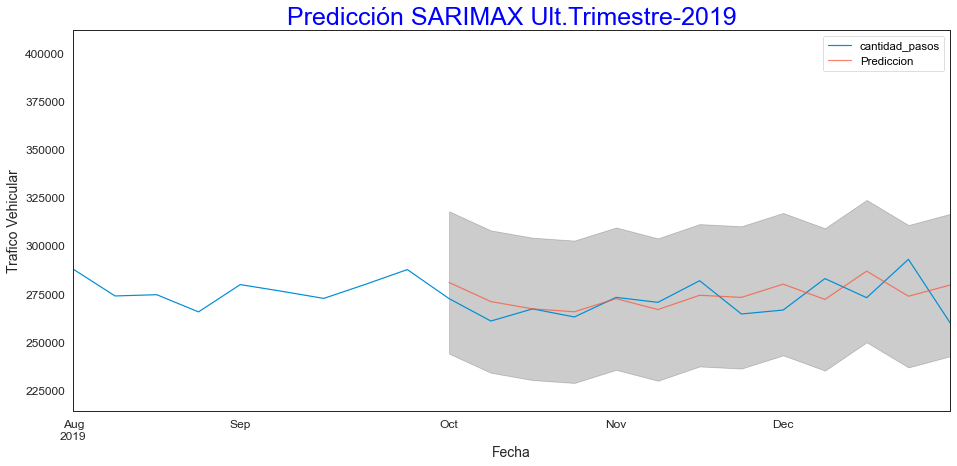

In [97]:
# pred = results.get_prediction(start=pd.to_datetime('2019-01-06'), dynamic=False) # Un año
# pred = results.get_prediction(start=pd.to_datetime('2019-06-02'), dynamic=False) # un semestre
pred = results.get_prediction(start=pd.to_datetime('2019-10-06'), dynamic=False) # un trimestre
pred_ci = pred.conf_int()
ax = semanal['2017':].plot(label='Trafico Real')
pred.predicted_mean.plot(ax=ax, label='Prediccion', alpha=.7, figsize=(14, 7))
plt.xlim(dt.datetime(2019,8,4), dt.datetime(2019,12,29))
plt.title("Predicción SARIMAX Ult.Trimestre-2019", color= 'blue', fontsize=25)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Trafico Vehicular')
plt.legend()
plt.show()

## ARIMA - Prediccion primer trimestre del 2020

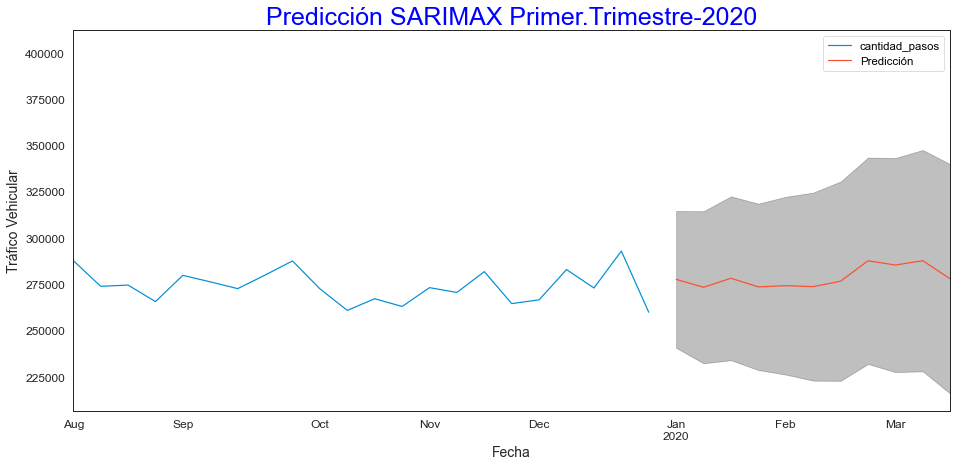

In [98]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = semanal.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Predicción')
plt.xlim(dt.datetime(2019,8,4), dt.datetime(2020,3,15))
plt.title("Predicción SARIMAX Primer.Trimestre-2020", color= 'blue', fontsize=25)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Tráfico Vehicular')
plt.legend()
plt.show()

In [99]:
# Cargo el csv con las predicciones 2020 del Proyecto 3
predicciones2020 = pd.read_csv('../DatasetsProyectos/predicciones2020.csv', sep =',')
PrimerTrimestre2020 = predicciones2020[:12]
PrimerTrimestre2020

# Agrego la prediccion de Arima para luego hacer el grafico de comparacion
PrimerTrimestre2020['ARIMA'] = pred_uc.predicted_mean.to_numpy()

# Entrenamiento y prediccion de un modelo LSTM

In [100]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [101]:
dataset = semanal.cantidad_pasos.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train.shape)

(124, 1)


In [102]:
# convertir una matriz de valores en una matriz de datos
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [103]:
# reshape into X=t and Y=t+1
look_back = 12
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [104]:
# realizo un reshape del input
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Entrenamiento


In [105]:
model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(100, input_shape=(12, 12)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=40, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Epoch 1/40
2/2 [==============================] - 0s 160ms/step - loss: 0.2756 - val_loss: 0.0611
Epoch 2/40
2/2 [==============================] - 0s 6ms/step - loss: 0.2258 - val_loss: 0.0477
Epoch 3/40
2/2 [==============================] - 0s 7ms/step - loss: 0.1810 - val_loss: 0.0362
Epoch 4/40
2/2 [==============================] - 0s 6ms/step - loss: 0.1407 - val_loss: 0.0265
Epoch 5/40
2/2 [==============================] - 0s 7ms/step - loss: 0.1084 - val_loss: 0.0185
Epoch 6/40
2/2 [==============================] - 0s 6ms/step - loss: 0.0823 - val_loss: 0.0123
Epoch 7/40
2/2 [==============================] - 0s 6ms/step - loss: 0.0602 - val_loss: 0.0077
Epoch 8/40
2/2 [==============================] - 0s 7ms/step - loss: 0.0447 - val_loss: 0.0047
Epoch 9/40
2/2 [==============================] - 0s 6ms/step - loss: 0.0303 - val_loss: 0.0030
Epoch 10/40
2/2 [==============================] - 0s 7ms/step - loss: 0.0233 - val_loss: 0.0025
Epoch 11/40
2/2 [====================

## LSTM - Prediccion

In [106]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_trainT = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_testT = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_trainT[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_trainT[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_testT[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_testT[0], test_predict[:,0])))

Train Mean Absolute Error: 18076.65776941117
Train Root Mean Squared Error: 23762.216157469233
Test Mean Absolute Error: 9456.453872921105
Test Root Mean Squared Error: 11520.051424256293


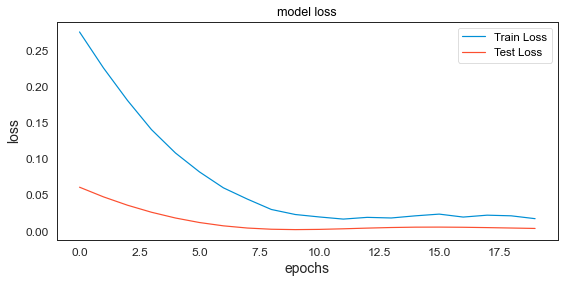

In [107]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

### Graficamos la prediccion

In [108]:
aa=[x for x in range(12)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_testT[0][:12], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:12], 'r', label="prediction")

plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Trafico Vehicular', size=15)
plt.xlabel('Fecha', size=15)
plt.legend(fontsize=15)
plt.show();

In [109]:
# guardo el resultado de la prediccion para luego graficar y comparar con los modelos anteriores
PrimerTrimestre2020['LSTM'] = test_predict[0:12]

In [110]:
# Tabla de resultados
PrimerTrimestre2020

fecha        prophet  bayesianRidge      real          ARIMA  \
0   2020-01-05  236796.113042  290558.713952  150623.0  277583.155866   
1   2020-01-12  233149.326251  275415.871194  243359.0  273333.788919   
2   2020-01-19  242187.093762  275583.655221  246818.0  278195.810179   
3   2020-01-26  254488.773408  270689.706527  241192.0  273549.547371   
4   2020-02-02  261405.120813  276615.300187  253335.0  274188.391727   
5   2020-02-09  261236.593000  271886.265345  247145.0  273686.039670   
6   2020-02-16  257644.060693  281672.939391  261458.0  276602.897231   
7   2020-02-23  254510.756226  279696.166485  257096.0  287639.006917   
8   2020-03-01  253221.632542  288295.928226  235487.0  285342.597611   
9   2020-03-08  253420.420204  283088.798914  254910.0  287707.827049   
10  2020-03-15  254315.773527  284132.798682  222793.0  277850.379324   
11  2020-03-22  254794.582980  280150.863922  107855.0  284798.105551   

            LSTM  
0   280726.21875  
1   280360.84375  
2   280819.34375  
3   278248.03125  
4   278207.53125  
5   283782.46875  
6   284950.59375  
7   284854.81250  
8   286103.81250  
9   283203.34375  
10  281848.31250  
11  279113.81250

## Grafico comparativo de los distintos modelos utilizados

<AxesSubplot:>

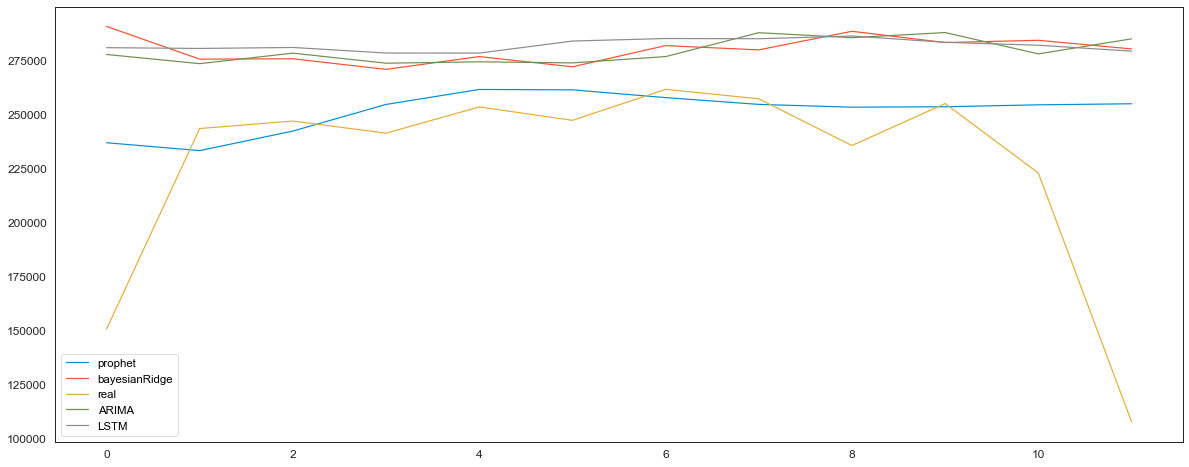

In [111]:
PrimerTrimestre2020.plot()

Tal como se puede apreciar en el gráfico comparativo, el Modelo **Prophet** es el mejor modelo que predijo el 2020.

Puede ser que se deba a que Prophet es resistente a valores atípicos, datos faltantes y cambios drásticos en su serie temporal.

## Conclusiones Finales
Este Proyecto requeririó la implementación de 2 nuevos Modelo de ML que no fueron visto en las clases, por lo que tuve el desafío de investigar, consultar y probar hasta lograr un resultado. Puedo considerar este trabajo como el ultimo aprendizaje del curso, ya que requirió tiempo y esfuerzo poder llevarlo adelante..

Con respecto al resultado obtenido, pensé que alguno de estos 2 nuevos modelos me daría un resultado mejor al obtenido en el Proyecto 3. Estimo que me falta profundizar en las distintas configuraciones posibles para asi obtener un mejor resultado. 

Nuestra tarea no tiene fin siempre seguiremos aprendiendo y mejorando en nuestra técnica, obteniendo resultados cada vez mas prometedores.

Me queda como desafío seguir estudiando y practicando.